# Web-scraping: сбор данных из баз данных и интернет-источников


## Практикум 2. Обработка таблиц внутри HTML с `BeautifulSoup` и `pandas`

*Алла Тамбовцева*

Импортируем библиотеки и функцию `BeautifulSoup` (понадобятся для примеров ниже):

* `requests` для отправки запроса и получения кода HTML веб-страницы;
* `bs4` для поиска тэгов в коде HTML;
* `pandas` для обработки полученной информации и приведения ее к табличному виду.

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

Итак, в первом домашнем задании мы посмотрели, как можно с помощью BeautifulSoup извлечь элементы из отдельных ячеек таблицы. На самом деле, в случае работы с большими таблицами можно поступать гораздо проще – задействовать специальную функцию `read_html()` из библиотеки `pandas`. Перейдем к более продвинутой задаче. Зайдем на сайт Левада-Центра и найдем на [странице](https://www.levada.ru/indikatory/) с индикаторами одобрения органов власти первую таблицу с данными (под первым графиком, имеет индекс 0):

In [2]:
page = requests.get("https://www.levada.ru/indikatory/")
soup = BeautifulSoup(page.text)
tab0 = soup.find_all("table", {"class" : "datatable"})[0]

Преобразуем объект `tab0` в строку, так как функция `read_html()` умеет работать только с обычными строками или файлами, а не с объектами `BeautifulSoup`, и создаем датафрейм на основе кода HTML, указав, что первая строка таблицы содержит заголовки столбцов (`header`):

In [3]:
df = pd.read_html(str(tab0), header = 0)[0]
df

,08.1999,09.1999,10.1999,11.1999,12.1999,01.2000,02.2000,03.2000,04.2000,05.2000,...,03.2023,04.2023,05.2023,06.2023,07.2023,08.2023,09.2023,10.2023,11.2023,12.2023
0,31,53,65,80,79,84,75,70,77,72,...,82,83,82,81,82,80,80,82,85,83
1,33,27,20,12,13,10,17,21,15,17,...,15,14,15,16,15,16,17,15,13,14
2,37,20,15,8,8,7,8,9,8,11,...,3,3,2,3,3,4,3,3,2,3


Ура! Одной строчкой кода мы получили красивую таблицу вместо «сырого» фрагмента HTML. Давайте транспонируем полученный датафрейм, чтобы получить более привычный вариант таблицы (и удобный для визуализации, если нас интересует динамика процента одобряющий и неодобряющих):

In [4]:
df = df.transpose() 
df

,0,1,2
08.1999,31,33,37
09.1999,53,27,20
10.1999,65,20,15
11.1999,80,12,8
12.1999,79,13,8
...,...,...,...
08.2023,80,16,4
09.2023,80,17,3
10.2023,82,15,3
11.2023,85,13,2


Обработаем этот датафрейм:

* добавим названия столбцов;
* извлечем даты из названией строк (атрибут `index`) и сохраним их в отдельный столбец;
* в качестве названий строк добавим набор целых чисел от 0 до 279;
* переставим столбцы местами – выбирем их в нужном порядке и перезаписываем `df`;

In [5]:
df.columns = ["yes", "no", "no answer"]

In [6]:
df["date"] = df.index

In [7]:
df.index = range(0, 291) 

In [8]:
df = df[["date", "yes", "no", "no answer"]]
df

,date,yes,no,no answer
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
286,08.2023,80,16,4
287,09.2023,80,17,3
288,10.2023,82,15,3
289,11.2023,85,13,2


Проверим типы столбцов:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       291 non-null    object
 1   yes        291 non-null    int64 
 2   no         291 non-null    int64 
 3   no answer  291 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.2+ KB


Все отлично, числовые данные сохранены как целые числа, но дату стоит перевести в специальный формат `datetime`, иначе сортировать данные и визуализировать их будет сложно – текст с датами не будет упорядочиваться хронологически. Воспользуемся функцией `to_datetime()` и укажем, в каком формате у нас сохранены даты (про форматы и соответствующие аббревиатуры можно почитать [здесь](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)):

In [10]:
# format: в каком формате даты в строке
# %m - шаблон для месяцев в числовом виде
# %Y – шаблон для лет в числовом виде (Y - 4 цифры, y – 2 цифры)

df["date"] = pd.to_datetime(df["date"], format = "%m.%Y")

Тип столбца изменился:

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       291 non-null    datetime64[ns]
 1   yes        291 non-null    int64         
 2   no         291 non-null    int64         
 3   no answer  291 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.2 KB


И для определенности к каждой дате (а у нас был только месяц и год) приписалось число – первый день месяца:

In [12]:
df.head()

,date,yes,no,no answer
0,1999-08-01,31,33,37
1,1999-09-01,53,27,20
2,1999-10-01,65,20,15
3,1999-11-01,80,12,8
4,1999-12-01,79,13,8


Проверим, что при визуализации динамики все будет в порядке, хронология не будет нарушена. Построим маленький базовый график с помощью функции `plot()`, без особых настроек, для примера. Импортируем модуль `pyplot`:

In [13]:
from matplotlib import pyplot as plt

Давайте в одной координатной плоскости построим сразу два графика – покажем динамику для процента одобряющих и неодобряющих деятельность Владимира Путина:

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and

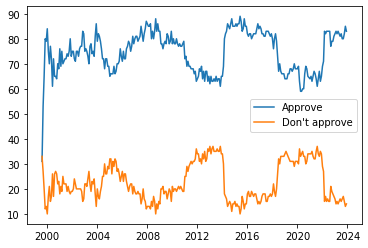

In [15]:
# много предупреждений – можем игнорировать или выключить, matplotlib предупреждает,
# что в будущей версии будет иной синтаксис и принцип работы
# label – чтобы назвать каждый график и отразить это в легенде

plt.plot(df["date"], df["yes"], label = "Approve")
plt.plot(df["date"], df["no"], label = "Don't approve")
plt.legend()

Отлично! График готов, похож на аналогичный график на сайте Левада-Центра. Конечно, размер и масштаб у этого графика не очень подходящие, но это всегда можно исправить (см. материалы по визуализации [здесь](http://math-info.hse.ru/s22/d)).